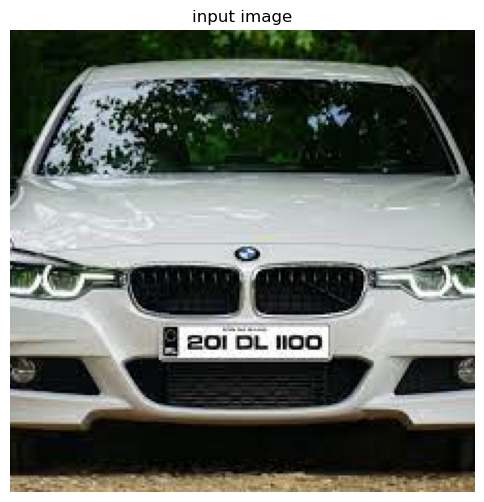

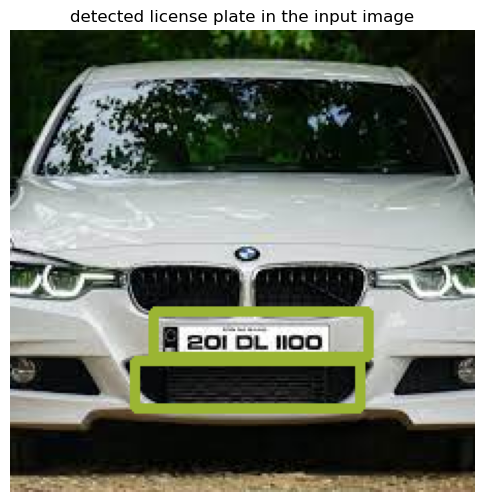

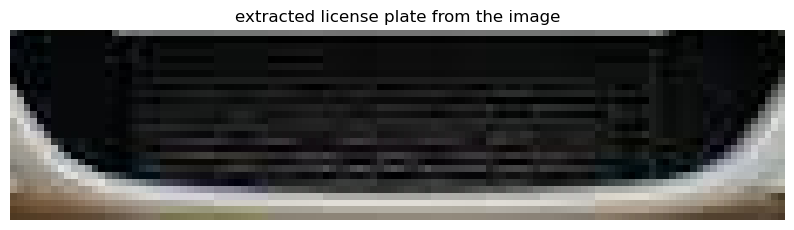

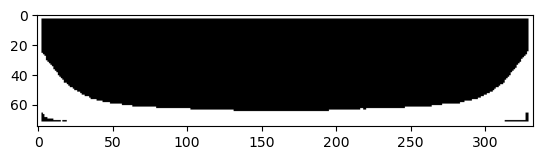

Found 861 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │        23,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,268 (2.89 MB)

 Trainable params: 757,268 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D 
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier(r"C:\Users\Skuad\Downloads\indian_license_plate.xml")
# add the path to 'india_license_plate.xml' file.

def detect_plate(img, text=''):  # the function detects and performs blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)  # detects number plates and returns the coordinates and dimensions of detected license plate's contours.
    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y + h, x:x + w, :]  # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y + h, x:x + w, :]
        cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 181, 155), 3)  # representing the detected contours by drawing rectangles around the edges.
    if text != '':
        plate_img = cv2.putText(plate_img, text, (x - w // 2, y - h // 2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate  # returning the processed image.


# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


img = cv2.imread(r"C:\Users\Skuad\Downloads\car.jpg")
display(img, 'input image')

# Getting plate from the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')
display(plate, 'extracted license plate from the image')


# Match contours to license plate or character template
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x coordinate of the character's contour, to be used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 6,
                  LP_WIDTH / 2,
                  LP_HEIGHT / 10,
                  2 * LP_HEIGHT / 3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


# Let's see the segmented characters
char = segment_characters(plate)

# Use the minimum of 10 or the length of `char` to avoid index out of bounds
num_characters_to_display = min(10, len(char))

for i in range(num_characters_to_display):
    plt.subplot(1, 10, i + 1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

plt.show()

# Prepare for training the model
train_datagen = ImageDataGenerator(rescale=1. / 255, width_shift_range=0.1, height_shift_range=0.1)
path = r"C:\Users\Skuad\Downloads\data\data"

train_generator = train_datagen.flow_from_directory(
    path + '/train',  # this is the target directory
    target_size=(28, 28),  # all images will be resized to 28x28
    batch_size=1,
    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
    path + '/val',  # this is the target directory
    target_size=(28, 28),  # all images will be resized to 28x28
    batch_size=1,
    class_mode='sparse')


# Metrics for checking the model performance while training
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')


def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)


K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22, 22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16, 16), activation='relu', padding='same'))
model.add(Conv2D(64, (8, 8), activation='relu', padding='same'))
model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=[custom_f1score])
model.summary()

# Show segmented characters and their predicted values
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:,:,i] = img
